In [1]:
import numpy as np,\
pandas as pd,\
seaborn as sns,\
matplotlib.pyplot as plt,\
sklearn.preprocessing as Scaler

import sklearn
from sklearn import linear_model
from sklearn import preprocessing

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

In [3]:
features_to_drop = ['GarageArea', 'TotRmsAbvGrd', 'TotalBsmtSF', 'Utilities']

features_to_trans = ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
                     'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
                     'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage',
                     'BsmtFinSF1', 'WoodDeckSF', '1stFlrSF',
                     'GrLivArea', 'BsmtUnfSF', '2ndFlrSF', 'HalfBath']

features_categorical = ['LotShape', 'OverallQual', 'OverallCond', 'LandContour', 'LotConfig',
                        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSZoning', 'MSSubClass',
                        'Street', 'Alley', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
                        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                        'GarageType']

features_numerical = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF',
                      '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'YrSold', 'YearBuilt',
                      'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'GarageYrBlt',
                      'YearRemodAdd','MoSold']

In [4]:
features_na_null = ['GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MSSubClass', 'Alley',
                   'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                   'GarageType']

features_na_zero = ['GarageYrBlt', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath',
                   'MasVnrArea']

In [7]:
# Randomize train_data before splitting
#
########################################
train_data = train_data.sample(frac = 1).reset_index(drop = True)
Y = train_data[['Id', 'SalePrice']]
all_data = pd.concat((train_data.drop(columns = ['SalePrice']), test_data))

In [15]:
all_data.groupby("Neighborhood")['LotFrontage'].sum()

Neighborhood
Blmngtn     938.0000
Blueste     273.0000
BrDale      645.0000
BrkSide    5300.0000
ClearCr    1763.0000
CollgCr   15694.0000
Crawfor    5806.0000
Edwards   11910.0000
Gilbert    8237.0000
IDOTRR     5415.0000
MeadowV     845.0000
Mitchel    6763.0000
NAmes     28204.0000
NPkVill     591.0000
NWAmes     6929.0000
NoRidge    4948.0000
NridgHt   13722.0000
OldTown   14147.0000
SWISU      2599.0000
Sawyer     7306.0000
SawyerW    7491.0000
Somerst   10457.0000
StoneBr    2860.0000
Timber     4626.0000
Veenker    1152.0000
Name: LotFrontage, dtype: float64

In [6]:
# Drop features and fill NA
#
#########################################

all_data = all_data.drop(columns = features_to_drop)

all_data['MSZoning'] = all_data['MSZoning'].fillna('RL')
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')
all_data['SaleType'] = all_data['SaleType'].fillna('WD')
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('VinylSd')
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('VinylSd')

all_data[features_na_null] = all_data[features_na_null].fillna("None")

all_data['LotFrontage'] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda col: 
                                                                                    col.fillna(col.dropna().median()))

all_data[features_na_zero] = all_data[features_na_zero].fillna(0)


In [7]:
# Apply log transform
#
#########################################

Y['SalePrice'] = np.log1p(Y['SalePrice'])
all_data[features_to_trans] = np.log1p(all_data[features_to_trans])

In [9]:
for feature in features_numerical:
    all_data[feature] = all_data[feature].astype(float)

In [10]:
# label encode features
#
##################################

for col in features_categorical:
# for col in cols:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(list(all_data[col].values))
    all_data[col] = le.transform(list(all_data[col].values))

In [11]:
###### assign dummy variable
#
#######################################

all_data_dum = pd.get_dummies(all_data.drop('Id', axis = 1))

In [12]:
all_data_dum.shape

(2919, 75)

In [13]:
# Convert Fake numerical Features to strings
# 
#######################################
# all_data_dum[['OverallQual', 'OverallCond', 'YearBuilt', 'MSSubClass']] = all_data_dum[
#     ['OverallQual', 'OverallCond', 'YearBuilt', 'MSSubClass']].astype(str)

In [14]:
def rmsError(x, y):
    return np.sqrt(np.sum(np.power(x - y, 2)) / len(x))

In [15]:
training_data = all_data_dum[:len(train_data)]

In [16]:
training_set = training_data[ : -400]
Y_training_set = Y['SalePrice'][ : -400]
# Y_training_set = Y[ : -400]

cv_set = training_data[-400 : ]
Y_cv_set = Y['SalePrice'][-400 : ]
# Y_cv_set = Y[-400 : ]

In [17]:
# test 1 : no regression, intercept calculation, no normalization
#
######################
test_model_1 = sklearn.linear_model.LinearRegression(copy_X = True)
test_model_1.fit(training_set, Y_training_set)
print("training error =\t", rmsError(test_model_1.predict(training_set), Y_training_set))
print("cv error =\t\t", rmsError(Y_cv_set, test_model_1.predict(cv_set)))

training error =	 0.11946772908232
cv error =		 0.1480418835129356


In [18]:
# test 1.1 : no regression, intercept calculation, normalization
#
######################
test_model_11 = sklearn.linear_model.LinearRegression(copy_X = True, normalize = True)
test_model_11.fit(training_set, Y_training_set)
print("training error =\t", rmsError(test_model_11.predict(training_set), Y_training_set))
print("cv error =\t\t", rmsError(Y_cv_set, test_model_11.predict(cv_set)))

training error =	 0.11946772908231985
cv error =		 0.1480418835129353


In [88]:
# test 1.2 : no regression, no intercept calculation
#
######################
test_model_12 = sklearn.linear_model.LinearRegression(copy_X = True, fit_intercept = False)
test_model_12.fit(training_set, Y_training_set)
print("training error =\t", rmsError(test_model_12.predict(training_set), Y_training_set))
print("cv error =\t\t", rmsError(Y_cv_set, test_model_12.predict(cv_set)))

training error =	 0.0833131264277798
cv error =		 0.13548829612898514


In [20]:
# Test 2 : Ridge Regression
#
############################
test_model_2 = sklearn.linear_model.Ridge(copy_X = True, fit_intercept = True, alpha = 3.1, tol = 0.000000001, max_iter = 10000000)
test_model_2.fit(training_set, Y_training_set)
print("training error =\t", rmsError(test_model_2.predict(training_set), Y_training_set))
print("cv error =\t\t", rmsError(Y_cv_set, test_model_2.predict(cv_set)))

training error =	 0.12118810549943475
cv error =		 0.14245198330071404


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

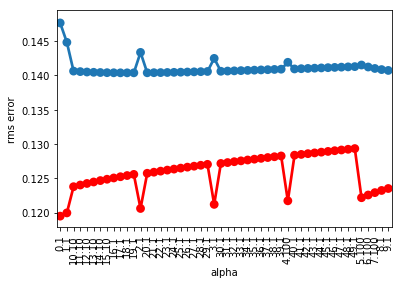

In [22]:
# Ridge alpha plot
#
############################
ar = []
ar2 = []
indices = []
for i in range(1, 500, 10):
    alpha = i * 0.1
#     alpha = (alpha * 1000) / 1000
    test_model_21 = sklearn.linear_model.Ridge(copy_X = True, fit_intercept = True, alpha = alpha, max_iter = 1000)
    test_model_21.fit(training_set, Y_training_set)
    ar.append(rmsError(test_model_21.predict(training_set), Y_training_set))
    ar2.append(rmsError(Y_cv_set, test_model_21.predict(cv_set)))
    indices.append(str(alpha)[:5])
    
fig = sns.pointplot(indices, ar, color = 'red', legend = True)
fig = sns.pointplot(indices, ar2)
fig.set(xlabel = 'alpha', ylabel = 'rms error')
plt.xticks(rotation = 90)
# fig.get_figure().savefig('../images/ridge_alpha.png', dpi = 500)

In [23]:
test_model_23 = sklearn.linear_model.Ridge(fit_intercept = True, alpha = 3.1, max_iter = 10000000)
test_model_23.fit(training_set, Y_training_set)
print("training error =\t", rmsError(test_model_23.predict(training_set), Y_training_set))
print("cv error =\t\t", rmsError(Y_cv_set, test_model_23.predict(cv_set)))
# print("alpha = ", test_model_23.alpha_)

training error =	 0.12118810549943475
cv error =		 0.14245198330071404


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

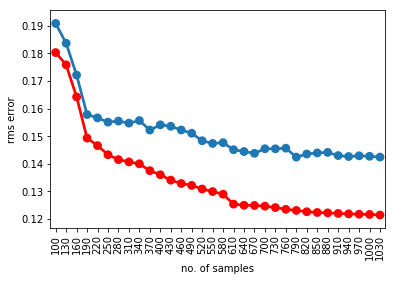

In [24]:
# ridge learning curve
#
####################################
ar = []
ar2 = []
indices = []
for i in range(100, len(training_set), 30):
#     alpha = i*.1
    test_model_22= sklearn.linear_model.Ridge(copy_X = True, fit_intercept = True, alpha = 3.1, max_iter = 10000000)
    test_model_22.fit(training_set[ : i], Y_training_set[ : i])
    ar.append(rmsError(test_model_22.predict(training_set), Y_training_set))
    ar2.append(rmsError(Y_cv_set, test_model_22.predict(cv_set)))
    indices.append(i)

fig = sns.pointplot(indices, ar, color = 'red', legend = True)
fig = sns.pointplot(indices, ar2)
fig.set(xlabel = 'no. of samples', ylabel = 'rms error')
plt.xticks(rotation = 90)
# fig.get_figure().savefig('../images/ridge_m.png', dpi = 500)

In [29]:
# Test 3 : Lasso Regression
#
############################
test_model_3 = sklearn.linear_model.Lasso(copy_X = True, fit_intercept = True, alpha = .0015, tol = 0.000000001,
                                          max_iter = 10000000)
test_model_3.fit(training_set, Y_training_set)
print("training error =\t", rmsError(test_model_3.predict(training_set), Y_training_set))
print("cv error =\t\t", rmsError(Y_cv_set, test_model_3.predict(cv_set)))

training error =	 0.12595863284506553
cv error =		 0.13548678548338483


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

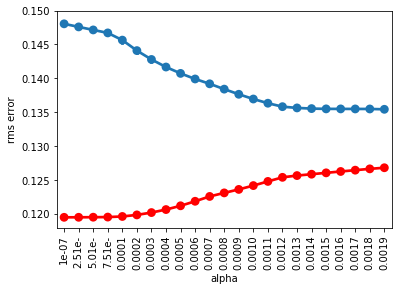

In [28]:
# Lasso alpha plot
#
############################
ar = []
ar2 = []
indices = []
for i in range(1, 20000, 250):
    alpha = i * 0.0000001
#     alpha = (alpha * 1000) / 1000
    test_model_31 = sklearn.linear_model.Lasso(copy_X = True, fit_intercept = True, alpha = alpha,
                                               max_iter = 10000)
    test_model_31.fit(training_set, Y_training_set)
    ar.append(rmsError(test_model_31.predict(training_set), Y_training_set))
    ar2.append(rmsError(Y_cv_set, test_model_31.predict(cv_set)))
    indices.append(str(alpha)[:6])
    
fig = sns.pointplot(indices, ar, color = 'red', legend = True)
fig = sns.pointplot(indices, ar2)
fig.set(xlabel = 'alpha', ylabel = 'rms error')
plt.xticks(rotation = 90)
# fig.get_figure().savefig('../images/lasso_alpha.png', dpi = 500)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

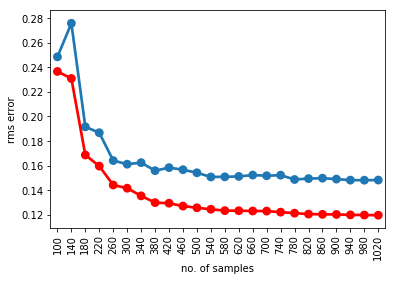

In [27]:
# lasso learning curve
#
####################################
ar = []
ar2 = []
indices = []
for i in range(100, len(training_set), 40):
#     alpha = i*.1
    test_model_32= sklearn.linear_model.Ridge(copy_X = True, fit_intercept = True, alpha = 0.0002, max_iter = 10000000)
    test_model_32.fit(training_set[ : i], Y_training_set[ : i])
    ar.append(rmsError(test_model_32.predict(training_set), Y_training_set))
    ar2.append(rmsError(Y_cv_set, test_model_32.predict(cv_set)))
    indices.append(i)

fig = sns.pointplot(indices, ar, color = 'red', legend = True)
fig = sns.pointplot(indices, ar2)
fig.set(xlabel = 'no. of samples', ylabel = 'rms error')
plt.xticks(rotation = 90)
# fig.get_figure().savefig('../images/lasso_m.png', dpi = 500)

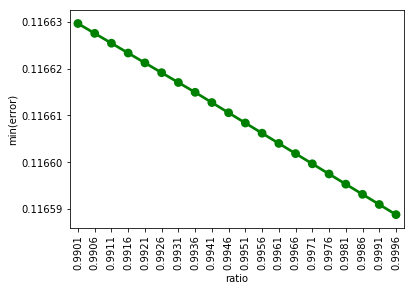

In [196]:
minar = []
ratios = []
for r in range(1, 100, 5):
#     print(r)
#     ratio = r * .01
    ratio = 0.99 + r * 0.0001
    ar = []
    ar2 = []
    indices = []
    for i in range(1, 2500, 250):
        alpha = i * .0001
        test_model_4 = sklearn.linear_model.ElasticNet(copy_X = True, fit_intercept = True, alpha = alpha, l1_ratio = ratio)    
        test_model_4.fit(training_set, Y_training_set)
        ar.append(rmsError(test_model_4.predict(training_set), Y_training_set))
        ar2.append(rmsError(Y_cv_set, test_model_4.predict(cv_set)))
        indices.append(str(alpha)[:6])
    minar.append(np.min(ar2))
    ratios.append(str(ratio)[:6])

figg = sns.pointplot(x = ratios, y = minar, color = 'green')
plt.xticks(rotation = 90)
figg.set(xlabel = 'ratio', ylabel = 'min(error)')
figg.get_figure().savefig('../images/elastic_ratio2.png', dpi = 500)

In [211]:
# Lasso output
#
############################
test_model_5 = sklearn.linear_model.Lasso(copy_X = True, fit_intercept = True, alpha = .0002, tol = 0.000000001,
                                          max_iter = 10000000)
test_model_5.fit(training_data, Y['SalePrice'])
print("training error =\t", rmsError(test_model_5.predict(training_set), Y_training_set))
print("cv error =\t\t", rmsError(Y_cv_set, test_model_5.predict(cv_set)))

training error =	 0.10419706413398194
cv error =		 0.09821391835749864


In [212]:
output = test_data[['Id']]

In [213]:
output

,Id
0,1461
1,1462
2,1463
3,1464
4,1465
5,1466
6,1467
7,1468
8,1469
9,1470


In [214]:
output['SalePrice'] = np.expm1(test_model_5.predict(all_data_dum[len(train_data):]))

In [215]:
output.to_csv('../Output/out.csv', index = False)

In [216]:
all_data_dum.shape

(2919, 446)